In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

# all the possible feature dimensions 
# NOTE: Capital 1st letter is the convention here
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"

HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"

# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/multi_sess/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/multi_sess/{sess_name}/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

DATA_MODE = "SpikeCounts"

### For whole population

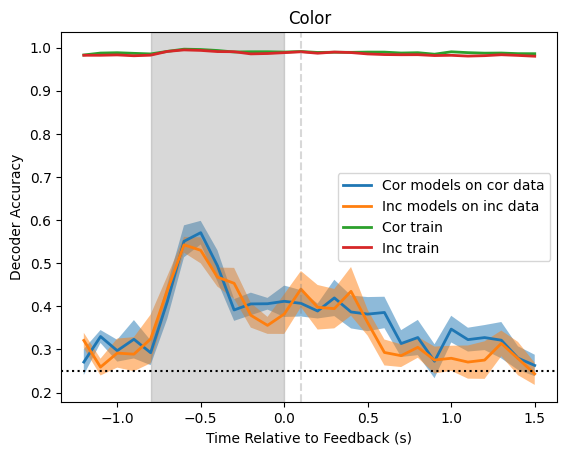

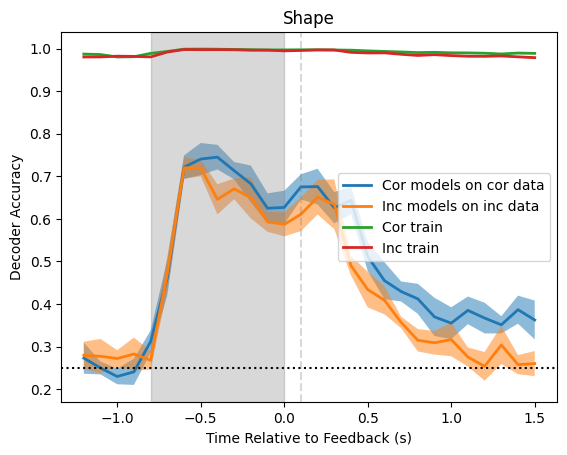

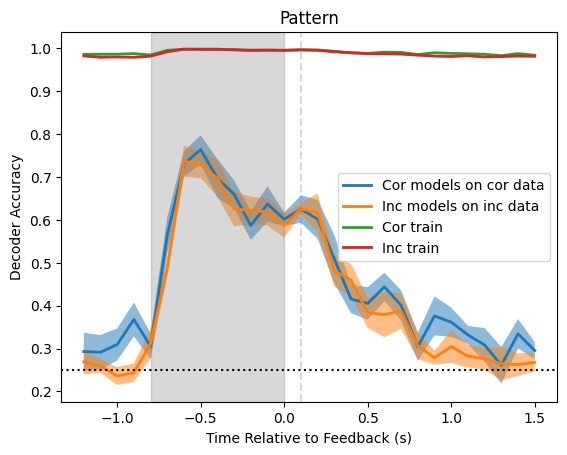

In [3]:
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    cor_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_test_accs.npy"))
    inc_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_test_accs.npy"))
    cor_train_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_train_accs.npy"))
    inc_train_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_train_accs.npy")) 
    cor_inc_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_cross_cor_models_inc_data_accs.npy"))
    inc_cor_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_cross_inc_models_cor_data_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Cor models on cor data",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        inc_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Inc models on inc data",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_train_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Cor train",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        inc_train_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Inc train",
        right_align=True, 
    )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     cor_inc_accs,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Cor models on inc data",
    #     right_align=True, 
    # )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     inc_cor_accs,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Inc models on cor data",
    #     right_align=True, 
    # )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(feature_dim)

### For state update subpop

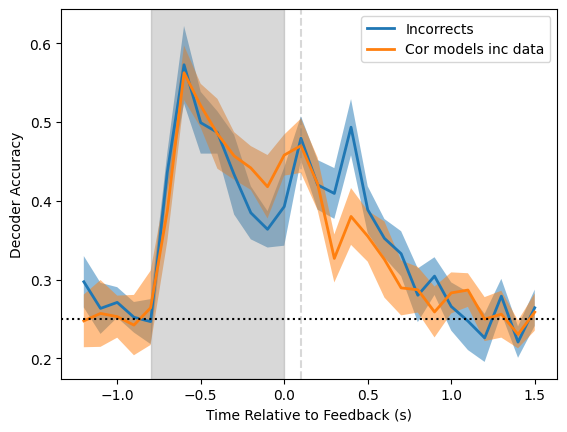

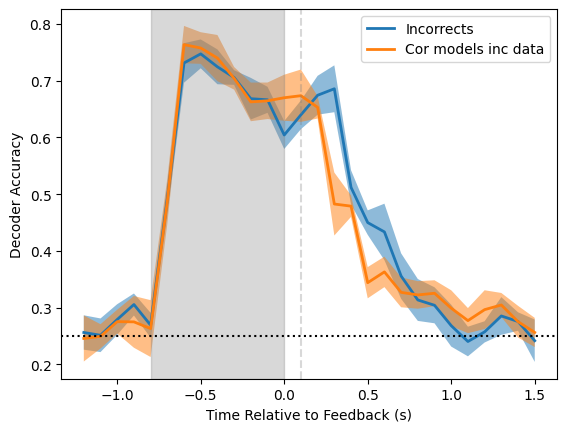

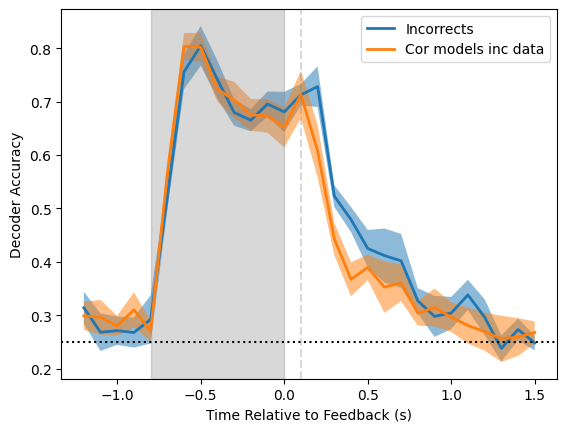

In [6]:
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    cor_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_state_update_cor_test_accs.npy"))
    inc_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_state_update_inc_test_accs.npy"))
    cor_inc_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_state_update_cross_cor_models_inc_data_accs.npy"))
    inc_cor_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_state_update_cross_inc_models_cor_data_accs.npy"))
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     cor_accs,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Corrects",
    #     right_align=True, 
    # )
    visualization_utils.visualize_accuracy_across_time_bins(
        inc_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Incorrects",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_inc_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Cor models inc data",
        right_align=True, 
    )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     inc_cor_accs,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Inc models cor data",
    #     right_align=True, 
    # )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")

### What about split by RPE groups?

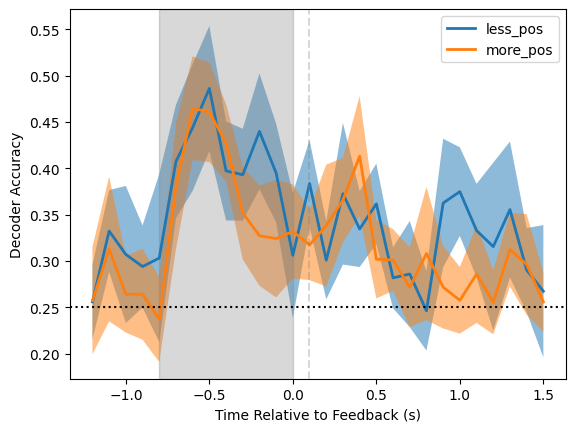

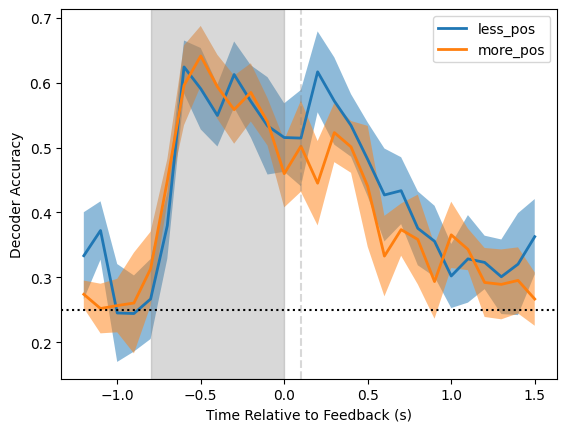

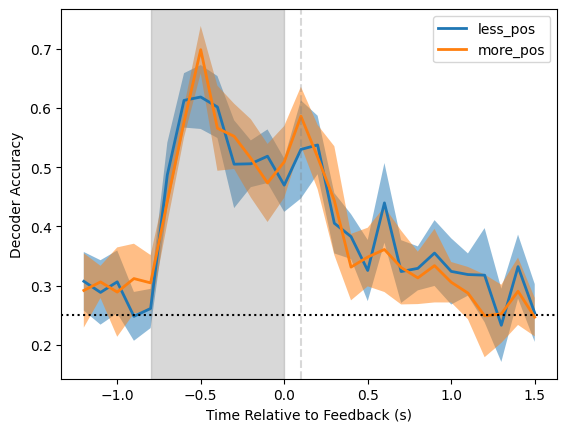

In [6]:
# rpe_groups = ["more_neg", "less_neg", "less_pos", "more_pos"]
rpe_groups = ["less_pos", "more_pos"]

for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    for group in rpe_groups:
        accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_{group}_test_accs.npy"))
        visualization_utils.visualize_accuracy_across_time_bins(
            accs,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=group,
            right_align=True, 
        )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")